In [1]:
from datetime import datetime 

from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

from sklearn.datasets import load_diabetes

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Урок 6. Градиентный бустинг. AdaBoost.

In [2]:
X, y = load_diabetes(return_X_y=True)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [3]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

def bias(y, z):
    return (y - z)

def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

1.Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [4]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees, max_depth, fit_seconds):
    print()    
    
    start_time = datetime.now()
    train_prediction = gb_predict(X_train, trees, coefs, eta)  
    predict_seconds = (datetime.now() - start_time).total_seconds()
    print(f'train\t{mean_squared_error(y_train, train_prediction):.0f}\t{n_trees}\t{max_depth}\t{eta}\t{fit_seconds:.3f}\t{predict_seconds:.3f}')

    start_time = datetime.now()
    test_prediction = gb_predict(X_test, trees, coefs, eta)  
    predict_seconds = (datetime.now() - start_time).total_seconds()
    print(f'test\t{mean_squared_error(y_test, test_prediction):.0f}\t{n_trees}\t{max_depth}\t{eta}\t{fit_seconds:.3f}\t{predict_seconds:.3f}')   
    
def gb_stat_plot(n_trees, max_depth, train_errors_arr, test_errors_arr):
    plt.figure(figsize=(20, 20))
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, max(n_trees))
    
    len_n_trees = len(n_trees)
    len_max_depth = len(max_depth)
    
    for i in range(len_n_trees - 1, -1, -1):
        x = list(range(n_trees[i]))
        
        for j in range(len_max_depth - 1, -1, -1):
            set_index = i * len_max_depth + j
            
            plt.plot(x, train_errors_arr[set_index], label=f'train | trees - {n_trees[i]} | max depth - {max_depth[j]}')
            plt.plot(x, test_errors_arr[set_index], label=f'test | trees - {n_trees[i]} | max depth - {max_depth[j]}')

            plt.scatter(x[0], train_errors_arr[set_index][0], marker=9, color='black', zorder=10)
            plt.scatter(x[-1], train_errors_arr[set_index][-1], marker=8, color='black', zorder=10)
            plt.scatter(x[0], test_errors_arr[set_index][0], marker=9, color='black', zorder=10)
            plt.scatter(x[-1], test_errors_arr[set_index][-1], marker=8, color='black', zorder=10)
            
    plt.legend(loc='upper right')
    plt.show()

In [5]:
# Число деревьев в ансамбле
n_trees = [10, 25, 50]

# для простоты примем коэффициенты равными 1
coefs = [el * [1] for el in n_trees]

# Максимальная глубина деревьев
max_depth = [3, 10, 20]

# Шаг
eta = 0.1

# Массивы наборов ошибок и решающих деревьев
trees_arr = []
train_errors_arr = []
test_errors_arr = []

In [6]:
print(f'\terror\ttrees\tmax\teta\tgb fit\tpredict')
print(f'\t\t\tdepth\t\ttime, s\ttime, s')

for i in range(len(n_trees)):
    for j in range(len(max_depth)):
    
        start_time = datetime.now()
        trees, train_errors, test_errors = gb_fit(n_trees[i], max_depth[j], X_train, X_test, y_train, y_test, coefs[i], eta)
        seconds = (datetime.now() - start_time).total_seconds()

        trees_arr.append(trees)
        train_errors_arr.append(train_errors)
        test_errors_arr.append(test_errors)

        evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs[i], eta, n_trees[i], max_depth[j], seconds)

	error	trees	max	eta	gb fit	predict
			depth		time, s	time, s

train	5701	10	3	0.1	2.169	0.201
test	6153	10	3	0.1	2.169	0.072

train	3584	10	10	0.1	2.141	0.201
test	7104	10	10	0.1	2.141	0.072

train	3514	10	20	0.1	2.162	0.204
test	7593	10	20	0.1	2.162	0.072

train	2050	25	3	0.1	14.093	0.505
test	3305	25	3	0.1	14.093	0.169

train	158	25	10	0.1	14.111	0.505
test	4408	25	10	0.1	14.111	0.172

train	149	25	20	0.1	14.294	0.509
test	6244	25	20	0.1	14.294	0.177

train	1377	50	3	0.1	57.500	1.001
test	3307	50	3	0.1	57.500	0.355

train	1	50	10	0.1	57.888	1.014
test	4431	50	10	0.1	57.888	0.347

train	1	50	20	0.1	58.141	1.062
test	6613	50	20	0.1	58.141	0.348


#### Вывод: 
#### - повышение максимальной глубины деревьев ведет к переобучению (ошибка на тренировочной выборке падает, а на тестовой - растет)
#### - повышение количества деревьев при всех прочих значениях улучшает алгоритм и приводит к понижению ошибки на обеих выборках

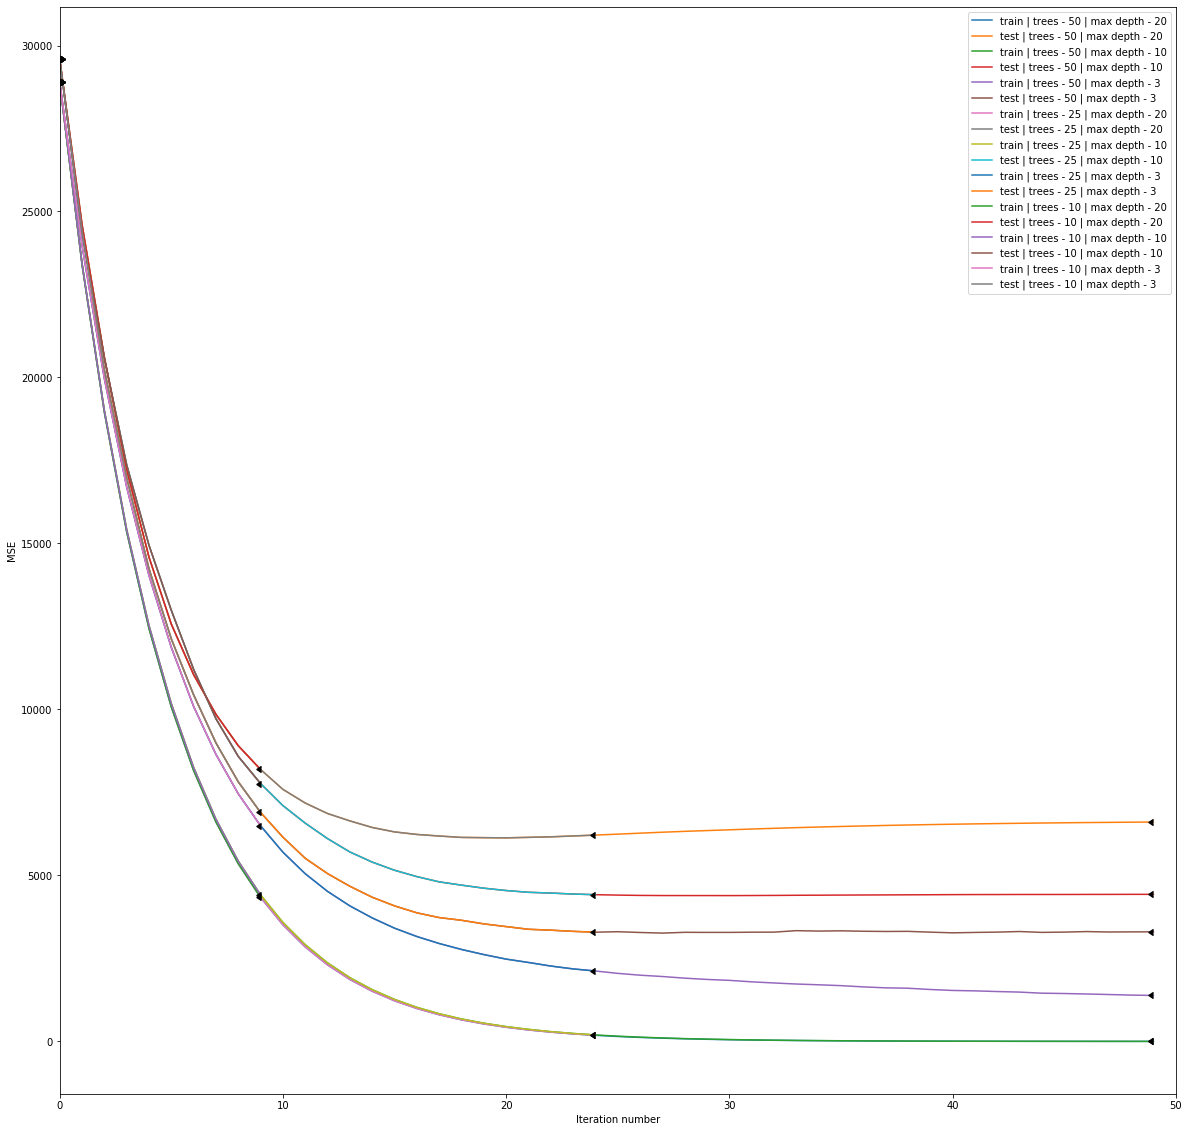

In [7]:
gb_stat_plot(n_trees, max_depth, train_errors_arr, test_errors_arr)

2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.